In [105]:
from firedrake import *
from pyadjoint import *
from cyipopt import *
import matplotlib.pyplot as plt
from firedrake.pyplot import triplot 
from firedrake.output import VTKFile
from firedrake.adjoint import *

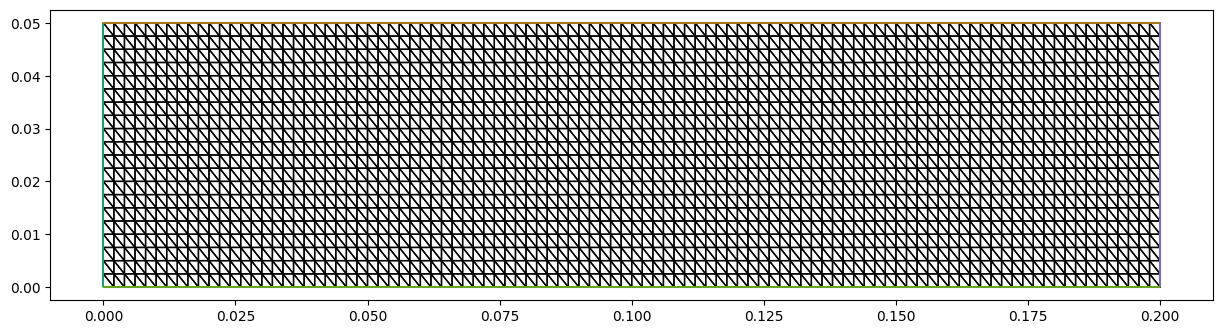

In [106]:
continue_annotation()

# Configuración de material (Acero estructural)
E = Constant(2e11)    # MPa (Módulo de Young)
nu = Constant(0.3)    # Coeficiente de Poisson
density = 7850        # kg/m³ (Densidad)
g = Constant(9.81)    # m/s² (Gravedad)

# Crear malla inicial 
mesh = RectangleMesh(100, 20, 0.20, 0.05)
V = VectorFunctionSpace(mesh, "CG", 1)  # Espacio para desplazamientos

# Graficar la malla
fig, ax = plt.subplots(figsize=(15,7))
triplot(mesh, axes=ax)
ax.set_aspect('equal')  # Mantiene la escala
plt.show()

In [107]:
def deform_mesh(control):
    deformed_coords = Function(V).interpolate(mesh.coordinates + control)
    mesh.coordinates.assign(deformed_coords)
    return mesh

# Cálculo de coeficientes mecánicos
mu = E/(2*(1 + nu))
lmbda = E*nu/((1+nu)*(1-2*nu))

def epsilon(u): return sym(grad(u))
def sigma(u): return lmbda * tr(epsilon(u)) * Identity(2) + 2.0 * mu * epsilon(u)

# Configurar problema de elasticidad lineal en tensión plana
def solve_elasticity(control):
    "Solver de elasticiladad lineal sobre malla deformada"
    deformed_mesh = deform_mesh(control)
    V_def = VectorFunctionSpace(deformed_mesh, "CG", 1)

    u = Function(V_def, name="Displacement")
    v = TestFunction(V_def)
    
    # Fuerzas: peso propio y carga externa
    body_force = Constant((0, -density * g))
    
    # Forma variacional
    F = inner(sigma(u), sym(grad(v))) * dx(domain=deformed_mesh) - inner(body_force, v) * dx(domain=deformed_mesh)

    # Condiciones de contorno
    bcs = [DirichletBC(V_def, Constant((0, 0)), 1)]
    
    solve(F == 0, u, bcs, annotate=True)

    return u, deformed_mesh

In [ ]:
# ---- Proceso de Optimización ----

# Definición de valores mínimos y máximos para desplazamiento

lb, ub = Function(V), Function(V)
x = SpatialCoordinate(mesh)

# Se genera un condicional que indique cuáles bordes no se moverán y cuánto se moverán otros 
expr_lb = conditional(x[0] < 1e-6, Constant((0.0, 0.0)), Constant((0, -0.005))) # Componentes (x, y)
expr_ub = conditional(x[0] < 1e-6, Constant((0.0, 0.0)), Constant((0,  0.005)))

lb.interpolate(expr_lb)
ub.interpolate(expr_ub)

# Definir control
control = Function(V, name="Control") # Vector de deformación

m = Control(control)

tape = get_working_tape()
tape.clear_tape()

u, deformed_mesh = solve_elasticity(control)

# Energía de deformación / energía elástica almacenada
J = assemble(inner(sigma(u), sym(grad(u))) * dx(deformed_mesh)) 

# Masa:
# J = assemble(Constant(1) * dx(domain=deformed_mesh))

# Regulación para smoothness en shape optimization
alpha = Constant(5e-3)
reg = assemble(alpha * inner(grad(control), grad(control)) * dx(deformed_mesh))
J = J + reg

# Uso de Pyadjoint
Jhat = ReducedFunctional(J, m)

# Definir problema de minimización
problem = MinimizationProblem(Jhat, bounds=(lb, ub))

# Configuración de solver con IPOPT
parameters = {"acceptable_tol": 1.0e-3, "maximum_iterations": 50, "linear_solver": "ma57", "print_level": 1}
solver = IPOPTSolver(problem, parameters)

# Solucionar
shape_opt = solver.solve()

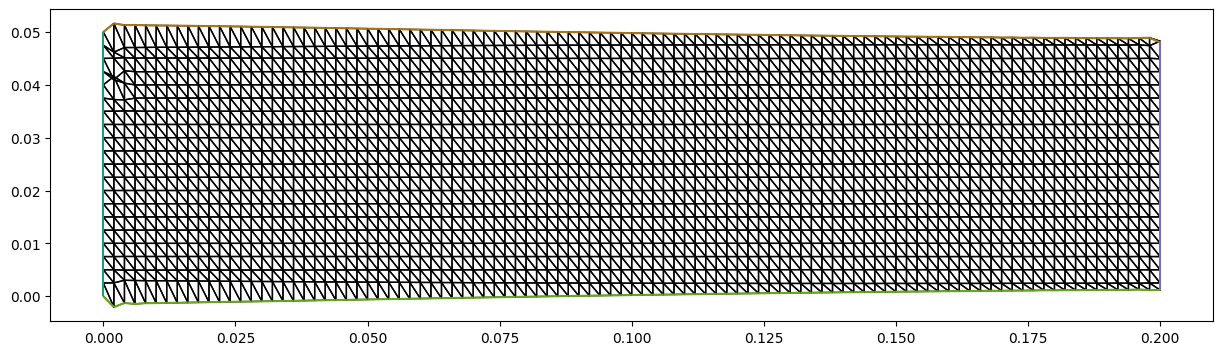

In [109]:
# Graficar la malla
fig, ax = plt.subplots(figsize=(15,9))
triplot(mesh, axes=ax)
ax.set_aspect('equal')  # Mantiene la escala
plt.show()

In [110]:
# print("Functional value:", float(J))

# print("Control norm:", norm(control))

# dJdm = compute_gradient(J, m)

# print(dJdm.dat.data_ro.max())

# try:
#     tape = get_working_tape()
#     tape.visualise("computational_graph.pdf")
#     print("Grafo computacional guardado como computational_graph.pdf")
# except Exception as e:
#     print(f"No se pudo visualizar el grafo: {str(e)}")

In [111]:
# # Definir el campo de control sinusoidal
# x, y = SpatialCoordinate(mesh)
# A = 0.005  # amplitud de la deformación
# kx = 10 * np.pi
# ky = 5 * np.pi
# control_expr = as_vector([
#     A * sin(kx * x) * sin(ky * y),  # componente x
#     A * cos(kx * x) * sin(ky * y)   # componente y
# ])
# control = Function(V, name="control").interpolate(control_expr)

# mesh_def = deform_mesh(control)

# # Graficar la malla
# fig, ax = plt.subplots(figsize=(15,7))
# triplot(mesh_def, axes=ax)
# ax.set_aspect('equal')  # Mantiene la escala
# plt.show()

### Prueba de movimiento de nodos

In [112]:
# result_files = VTKFile("solution.pvd")
# result_files.write(shape_opt, u, time = 0.0)